## Lettuce Detectio with Detecto

This notebook is a simple example of how to use the Detecto python library to detect lettuce in aerial drone images. The Detecto library is a PyTorch-based library that simplifies the process of training object detection models. 

This notebook accomplishes the following tasks:
1. Connects to Data to Science platform (https://ps2.d2s.org) to access the drone imagery. The dataset is an orthomosaic of a lettuce field near Yuma, Arizona.
2. Downloads (from Huggingface) an object detection machine learning model that has been fine-tuned to detect lettuce. The model is based on the Faster R-CNN architecture. It was trained by PhytoOracle, a research group at the University of Arizona. It was trained on Maricopa Ag Center gantry images at very high-resolution (millimeters). It is trained to use RGB images and put bounding boxes around lettuce plants.
3. Outputs the detected lettuce bounding boxes as a polygon shapefile layer with the same geographic coordinate system as the input drone image. 
4. Demonstrates how to fine-tune the model on a small dataset of annotated lettuce images.

In [1]:
#Import libraries for D2S and leafmap

from datetime import date

from d2spy.workspace import Workspace

import os

import leafmap

In [2]:
#Import necessary modules from Detecto python library
from detecto.core import Model #bring in the Faster R-CNN ResNet50 FPM model
from detecto.utils import read_image
from detecto.visualize import show_labeled_image

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
import geopandas as gpd
from shapely.geometry import box
import rasterio

In [5]:
# Connect to Purdue hosted D2S instance. It will prompt for your D2S password.
workspace = Workspace.connect("https://ps2.d2s.org", "jgillan@arizona.edu")

In [6]:
# Get list of all your projects
projects = workspace.get_projects()

# Check if there are any projects
if len(projects) > 0:
    # Loop through all projects and print each one
    for project in projects:
        print(f"ID: {project.id}")
        print(f"Title: {project.title}")
        print(f"Description: {project.description}\n")
else:
    print("Please create a project before proceeding with this guide.")


ID: ace74e20-ceec-45cd-b260-2a0f1c50b420
Title: Holiday Beach
Description: After Hurricane Harvey Survey

ID: 91509636-98e7-4e2c-9a68-e9006846b52f
Title: Purdue PUSH
Description: Purdue University Student Health Service building

ID: c15b0825-6e74-4899-b6bd-2917ce1ae3bd
Title: OsaLarge
Description: Large area including the Osa Conservation base camp.

ID: 77a769b0-61af-4813-894a-746001759f67
Title: Biosphere 2
Description: UAS Summit On Open Science & Data Management

ID: 2f939aa4-95e0-4b33-b0bb-e144207044ab
Title: Santa Rita Experimental Range
Description: Drone Imagery from 2019 collection

ID: 62773825-5d03-4eb0-8439-a463c0e09b0b
Title: Cornell Wheat - 2023
Description: T3 <-> UASHUB

ID: 2f27061b-2d66-41bd-9fd5-fc038ad34496
Title: Peanut Demo
Description: Demonstrating cloud data processing example

ID: fbac2a0a-1c7f-4add-b276-0c2a6644711a
Title: Paradise Valley Country Club
Description: Topographic surveying of the golf course for the purpose of installing subsurface drip irrigati

In [7]:
###Choose a project (from the previous print) and list all flights for that project

# Define the project ID you're looking for
#project_id = "46669dd1-3c9a-487e-adaa-92dd50bf0420"
project_id = "cfb77a4a-a065-400e-ae12-2cf11bf7c25b"


# Find the project by ID
selected_project = None
for project in projects:
    if project.id == project_id:
        selected_project = project
        break

# Check if the project was found
if selected_project:
    # Get list of all flights for the selected project
    flights = selected_project.get_flights()

    # Check if there are any flights
    if len(flights) > 0:
        # Loop through all flights and print each one
        for flight in flights:
            print(flight)
    else:
        print("No flights found for this project.")
else:
    print(f"Project with ID '{project_id}' not found.")

Flight(acquisition_date='2020-10-06', name='Smithfield_50ft', altitude=20.0, side_overlap=60.0, forward_overlap=75.0, sensor='RGB', platform='Phantom_4')


In [8]:
# Get list of data products from a flight. O in this case is the first flight listed.
data_products = flights[0].get_data_products()

# Check if there are any data products
if len(data_products) > 0:
    # Loop through all data products and print their URLs
    for product in data_products:
        print(product.url)
else:
    print("No data products found for this flight.")


https://ps2.d2s.org/static/projects/cfb77a4a-a065-400e-ae12-2cf11bf7c25b/flights/20812f2d-4b31-45b0-9b2f-66595aac16fa/data_products/ed454526-6e85-49f8-a274-fafda388abdd/b1cdf543-0dfd-4da7-b258-edb2fad2f5bd.tif
https://ps2.d2s.org/static/projects/cfb77a4a-a065-400e-ae12-2cf11bf7c25b/flights/20812f2d-4b31-45b0-9b2f-66595aac16fa/data_products/08bc3a6e-5ef9-45e8-b4b8-4face6f40ce2/e16b4c86-8476-4eab-af30-2a0befab1bfc.tif


In [9]:
# Interactive leafmap Map
os.environ["TITILER_ENDPOINT"] = "https://tt.d2s.org"

m = leafmap.Map()

# URL for a D2S hosted GeoTIFF data product
ortho_url = "https://ps2.d2s.org/static/projects/cfb77a4a-a065-400e-ae12-2cf11bf7c25b/flights/20812f2d-4b31-45b0-9b2f-66595aac16fa/data_products/ed454526-6e85-49f8-a274-fafda388abdd/b1cdf543-0dfd-4da7-b258-edb2fad2f5bd.tif"

# Add a publicly available data product to the map
m.add_cog_layer(ortho_url, name="Orthomosaic")

# If you want to display a private data product, comment out the previously line and uncomment the below m.add_cog_layer line
# Add a private data product to the map
# m.add_cog_layer(f"{ortho_url}?API_KEY={api_key}", name="DSM", colormap_name="rainbow")

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [5]:
#Download the image from D2S to the local directory
#!wget https://ps2.d2s.org/static/projects/46669dd1-3c9a-487e-adaa-92dd50bf0420/flights/72e1b4a1-68ea-48bf-85d1-4f6315cd78bd/data_products/fcb09a00-181c-4e3c-ba89-e58c7e7a7223/3ac72e63-64fe-4713-af0b-c332b3851032.tif

#!wget https://ps2.d2s.org/static/projects/cfb77a4a-a065-400e-ae12-2cf11bf7c25b/flights/20812f2d-4b31-45b0-9b2f-66595aac16fa/data_products/ed454526-6e85-49f8-a274-fafda388abdd/b1cdf543-0dfd-4da7-b258-edb2fad2f5bd.tif

#Return the path of the downloaded image 
image_path = "b1cdf543-0dfd-4da7-b258-edb2fad2f5bd.tif"


In [9]:
#Download the fine-tuned model (lettuce detection) from Hugging Face
!wget https://huggingface.co/jgillan/phytooracle_lettuce_2/resolve/main/model_weights.pth


--2024-10-27 20:33:36--  https://huggingface.co/jgillan/phytooracle_lettuce_2/resolve/main/model_weights.pth
Resolving huggingface.co (huggingface.co)... 18.238.109.92, 18.238.109.52, 18.238.109.121, ...
Connecting to huggingface.co (huggingface.co)|18.238.109.92|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/97/92/979239b2b3de32fe9f27b49a95a9f05143f15daa6bd1473652c850bd5d752d7c/90bf60c4e8ce0b9f390f4d1887f336087a39ddb9c9199a7bff3198e44f523a00?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model_weights.pth%3B+filename%3D%22model_weights.pth%22%3B&Expires=1730345617&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMDM0NTYxN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzk3LzkyLzk3OTIzOWIyYjNkZTMyZmU5ZjI3YjQ5YTk1YTlmMDUxNDNmMTVkYWE2YmQxNDczNjUyYzg1MGJkNWQ3NTJkN2MvOTBiZjYwYzRlOGNlMGI5ZjM5MGY0ZDE4ODdmMzM2MDg3YTM5ZGRiOWM5MTk5YTdiZmYzMTk4ZTQ0ZjUyM2EwMD9yZ

In [6]:
#declare the labels for the fine-tuned model
labels = [
    'lettuce'
]

In [7]:
#Load the fine-tuned model
model = Model.load('model_weights.pth', labels) 

In [8]:
##Define function to crop the remotely sensed image into tiles, 
# run predictions on each tile, and display the predictions on the original image

# Disable the image size limit of PIL
Image.MAX_IMAGE_PIXELS = None

# Step 1: Crop the large image into tiles
def crop_image_into_tiles(image_path, tile_size, output_folder):
    image = Image.open(image_path)
    img_width, img_height = image.size
    tiles_with_coordinates = []

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    tile_num = 0
    for y in range(0, img_height, tile_size):
        for x in range(0, img_width, tile_size):
            box = (x, y, min(x + tile_size, img_width), min(y + tile_size, img_height))
            tile = image.crop(box)

            if tile.mode == 'RGBA':  # Convert to RGB if needed
                tile = tile.convert("RGB")

            tile_path = os.path.join(output_folder, f'tile_{tile_num}.jpg')
            tile.save(tile_path, 'JPEG')
            tiles_with_coordinates.append((tile_path, (x, y)))
            tile_num += 1

    return tiles_with_coordinates

# Step 2: Run predictions on each tile
def get_predictions_for_tiles(tiles_with_coordinates, model, threshold=0.3):
    all_predictions = []

    for tile_path, (tile_x, tile_y) in tiles_with_coordinates:
        tile = Image.open(tile_path)
        
        # Run prediction on tile
        labels, boxes, scores = model.predict(tile)
        
        # Store the predictions with the tile's coordinates
        all_predictions.append((labels, boxes, scores, tile_x, tile_y))

    return all_predictions

# Step 3: Adjust and display predictions on the original image
def adjust_boxes(boxes, tile_x, tile_y):
    adjusted_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        adjusted_box = [x_min + tile_x, y_min + tile_y, x_max + tile_x, y_max + tile_y]
        adjusted_boxes.append(adjusted_box)
    return adjusted_boxes

def display_original_image_with_boxes(image_path, all_predictions, threshold=0.3):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(100, 100))
    ax.imshow(image)

    for labels, boxes, scores, tile_x, tile_y in all_predictions:
        adjusted_boxes = adjust_boxes(boxes, tile_x, tile_y)

        for i, box in enumerate(adjusted_boxes):
            if scores[i] > threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=3, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                #label_text = f'{labels[i]}: {scores[i]:.2f}' # Uncomment these lines to display labels and scores
                #plt.text(x_min, y_min - 10, label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()



In [11]:

# Define the output folder and tile size
output_folder = 'cropped_tiles'
tile_size = 1024  # Adjust as needed

# Run the tiling function
tiles_with_coordinates = crop_image_into_tiles(image_path, tile_size, output_folder)

# Run predictions on each tile
#all_predictions = get_predictions_for_tiles(tiles_with_coordinates, model, threshold=0.15)


In [ ]:
# Display all predictions on the original large image
display_original_image_with_boxes(image_path, all_predictions, threshold=0.3)

In [11]:
#Define function to create a georeferenced shapefile from the predictions

def create_georeferenced_shapefile(all_predictions, image_path, output_shapefile, threshold):
    # Open the original image to retrieve CRS and affine transform
    with rasterio.open(image_path) as src:
        crs = src.crs  # CRS of the original image (EPSG:32611)
        transform = src.transform  # Affine transformation matrix for the full image

    # List to hold each bounding box with its label and score
    polygons = []

    # Collect bounding boxes in terms of full image coordinates (not tile-based)
    for labels, boxes, scores, tile_x, tile_y in all_predictions:
        for i, box_coords in enumerate(boxes):
            if scores[i] >= threshold:  # Apply confidence threshold
                # Calculate full-image coordinates for each bounding box
                x_min, y_min, x_max, y_max = box_coords
                x_min += tile_x
                y_min += tile_y
                x_max += tile_x
                y_max += tile_y

                # Create a Polygon in image (pixel) coordinates
                polygon = box(x_min, y_min, x_max, y_max)
                polygons.append({
                    'geometry': polygon,
                    'label': labels[i],
                    'score': scores[i]
                })

    # Create a GeoDataFrame with pixel-based coordinates
    gdf_pixel = gpd.GeoDataFrame(polygons, crs="EPSG:32611")

    # Apply affine transform to convert pixel coordinates to geographic coordinates
    gdf_pixel['geometry'] = gdf_pixel['geometry'].apply(
        lambda geom: transform_polygon(geom, transform)
    )

    # Set CRS and save to shapefile
    gdf_pixel.set_crs(crs, inplace=True)
    gdf_pixel.to_file(output_shapefile, driver="ESRI Shapefile")

def transform_polygon(geometry, transform):
    # Convert each coordinate in the Polygon to geographic coordinates using affine transform
    transformed_coords = [(transform * (x, y)) for x, y in geometry.exterior.coords]
    return box(*transformed_coords[0], *transformed_coords[2])




In [12]:
#Execute the function to create the georeferenced shapefile
output_shapefile = "predicted_please_work.shp"
create_georeferenced_shapefile(all_predictions, image_path, output_shapefile, threshold=0.15)

In [24]:
# Removes access token from future requests
workspace.logout()

session ended


## Fine-tune a model with training data

In [13]:
# Import necessary module
from detecto.core import Dataset


# create the datasets
dataset = Dataset(label_data='./lettuce_training/Annotations/', image_folder='./lettuce_training/images/')

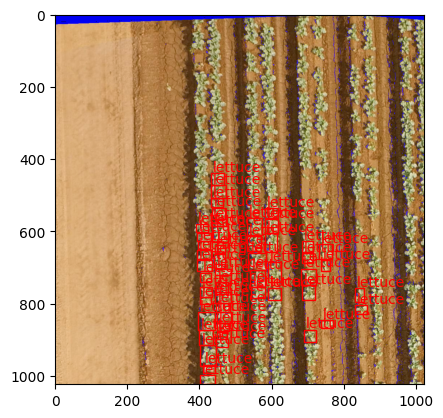

In [16]:
# we can also visualize the validation dataset
image, target = dataset[0]
show_labeled_image(image, target['boxes'], target['labels'])

In [17]:
#import necessary modules
from detecto.core import DataLoader, Model

# wrap the training set in a DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# specify all unique labels you're trying to predict
labels = [
    'lettuce'
]

In [18]:
##TRAINING RUN!!
# initialize a model with the target labels and fit the model
# This step will take some time and is accelerated with GPU
losses = model.fit(train_loader,
                   epochs=8,
                   lr_step_size=5,
                   learning_rate=0.001,
                   verbose=True)

It looks like you're training your model on a CPU. Consider switching to a GPU; otherwise, this method can take hours upon hours or even days to finish. For more information, see https://detecto.readthedocs.io/en/latest/usage/quickstart.html#technical-requirements
Epoch 1 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 2 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 3 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 4 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch 5 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch 6 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 7 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Epoch 8 of 8
Begin iterating over training dataset


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


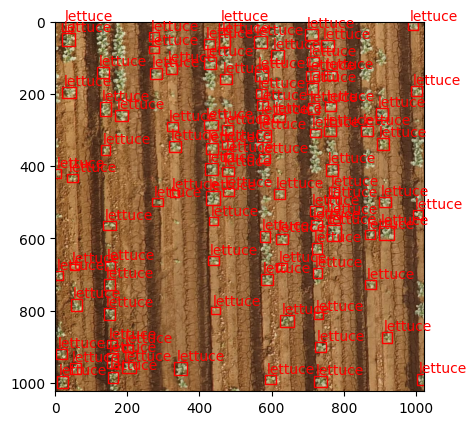

In [20]:
image = read_image('./cropped_tiles/tile_246.jpg')
labels, boxes, scores = model.predict(image)
show_labeled_image(image, boxes, labels)